In [91]:
# utility
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import norm, probplot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import warnings

warnings.filterwarnings('ignore')

dataset = arff.loadarff('./data/ames_housing.arff')
data = pd.DataFrame(dataset[0])

print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

Number of rows in the data: 2930
Number of columns in the data: 81


## Rimozione Pool_Qc
Abbiamo rimosso Pool_Qc perchè essa è già rappresentata dalla feature Pool_Area

In [92]:
data = data.drop(labels='Pool_QC', axis=1)

## Divisione del dataset in train set e test set


In [93]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2344, 79), (586, 79), (2344,), (586,))

# Trasformazione features categoriche in numeriche ordinali

In [94]:
def refine_data(x_train, y_train, x_test, feature_name):
    xy_train = pd.concat([x_train, y_train], axis=1)

    feat_order = xy_train.groupby([feature_name]).median().Sale_Price.sort_values(ascending=True).index

    # replace con l'ordinamento trovato
    order = dict(zip(feat_order, range(len(feat_order.to_list()))))
    x_train = x_train.replace({feature_name: order})

    # trasformiamo anche il test
    x_test = x_test.replace({feature_name: order})
    # se ci sono valori nuovi nel test allora li rimpiazziamo con la media
    x_test[feature_name][[True if type(e) == bytes else False for e in x_test[feature_name]]] = order.get(
        list(order)[-1]) // 2

    # Create box plot
    plt.figure(figsize=(18, 8))
    sns.boxplot(x=feature_name,
                y='Sale_Price',
                data=pd.concat([x_train, y_train], axis=1),
                palette='GnBu_r')

    x_train = x_train.astype({feature_name: 'int64'})
    x_test = x_test.astype({feature_name: 'int64'})

    return x_train, x_test

controllo se Neighborhood ha un qualche ordinamento rispetto a Sale_Price e in caso la trasformo in numerica

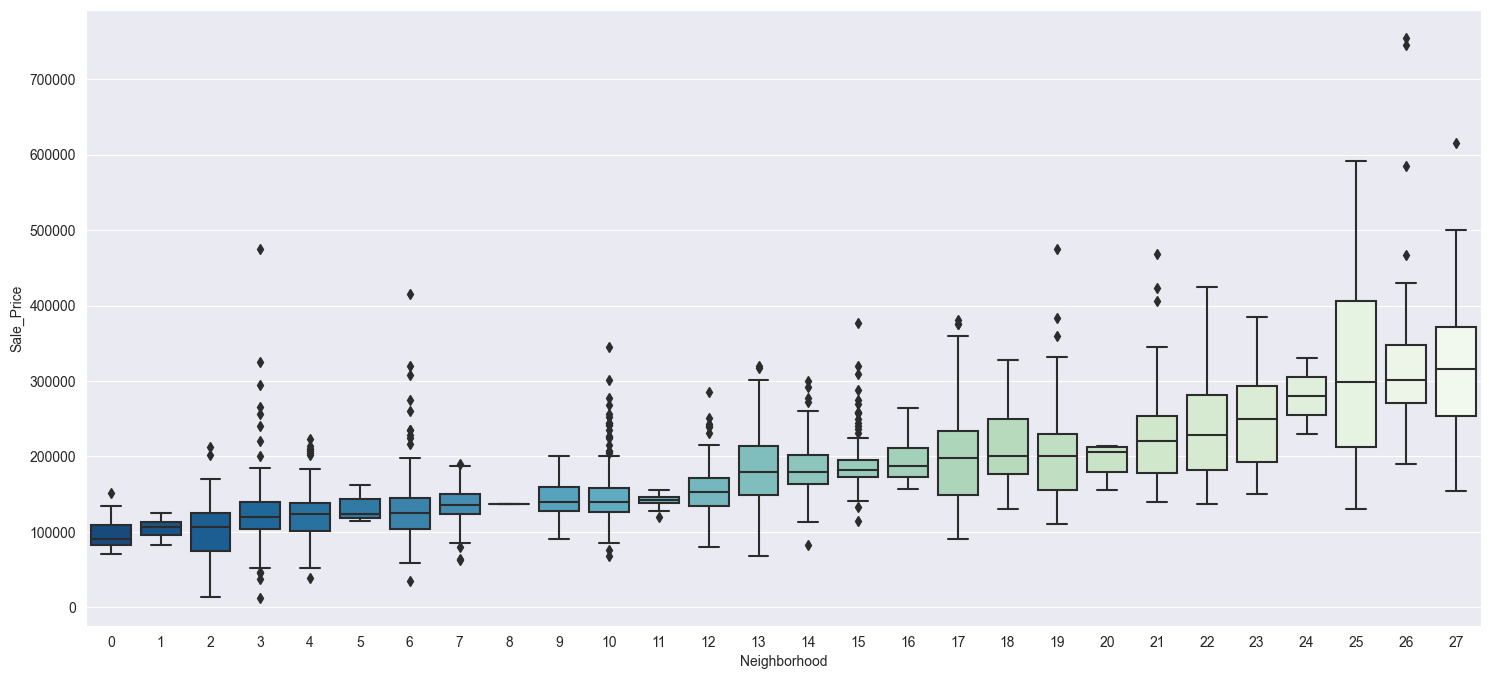

In [95]:
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Neighborhood')

stesso procedimento per Overall_Qual e Overall_Cond

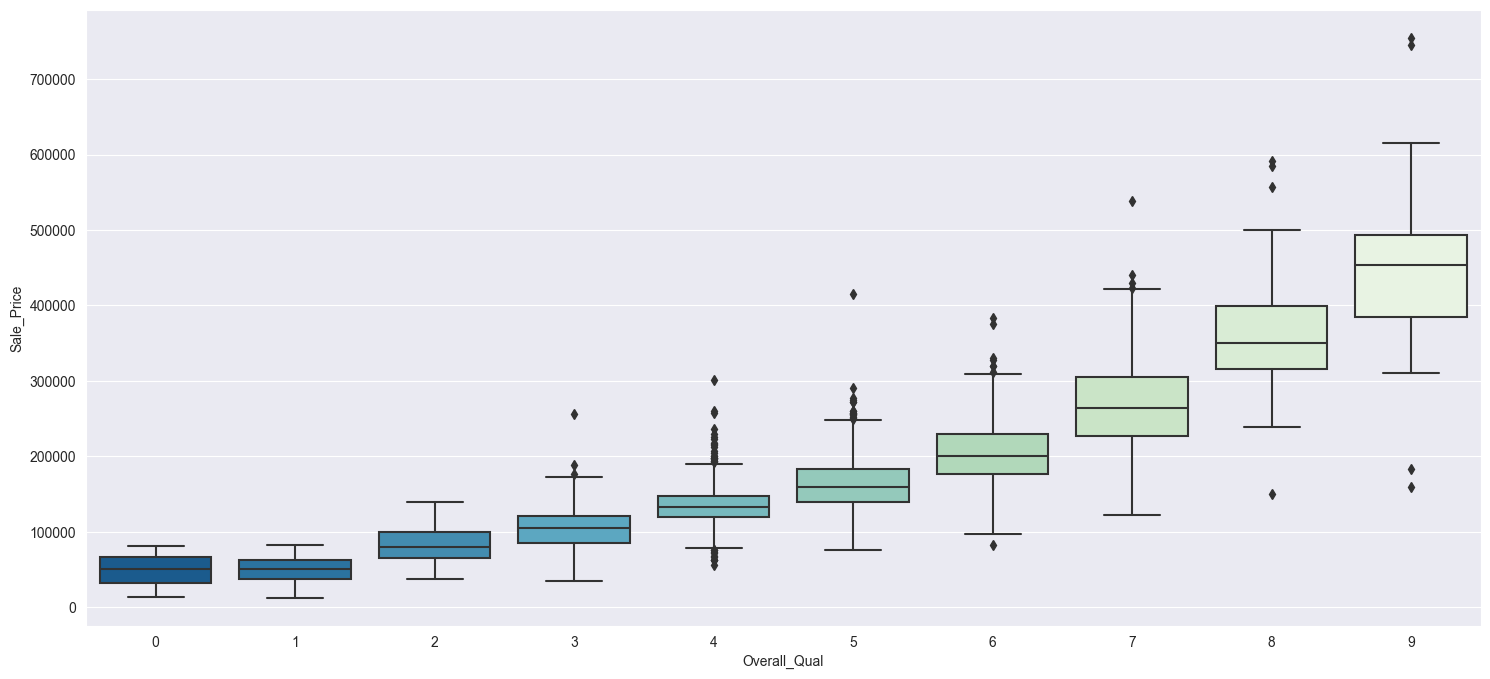

In [96]:
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Overall_Qual')

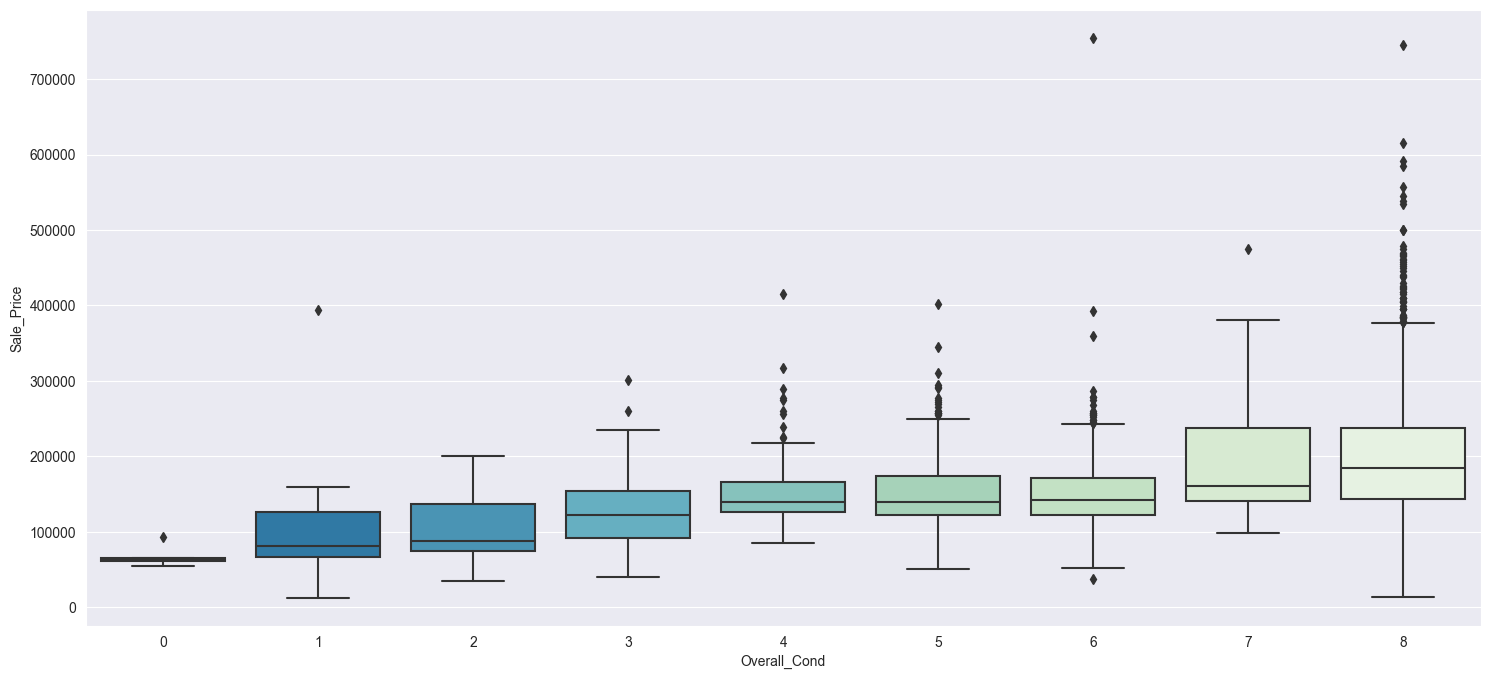

In [97]:
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Overall_Cond')

trasformiamo tutte le altre variabili categoriche che abbiamo notato avere un andamento crescente

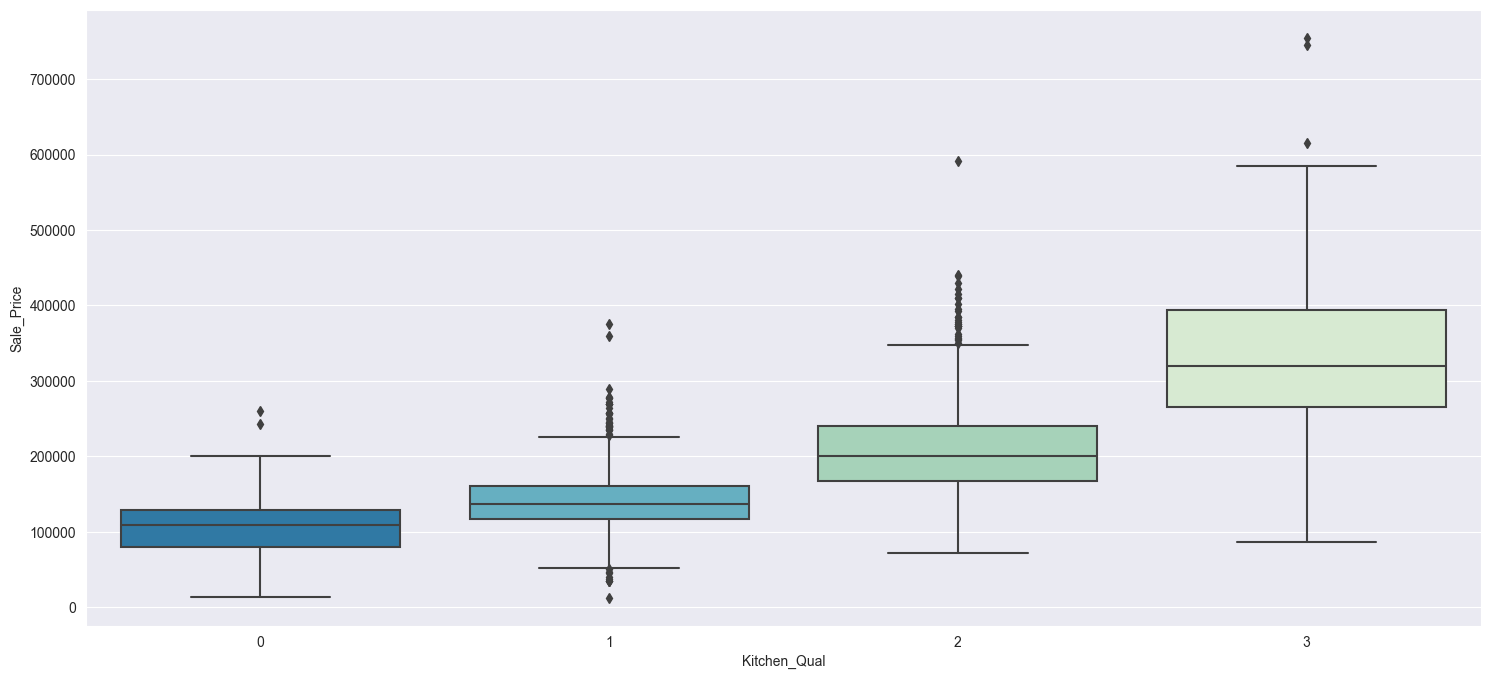

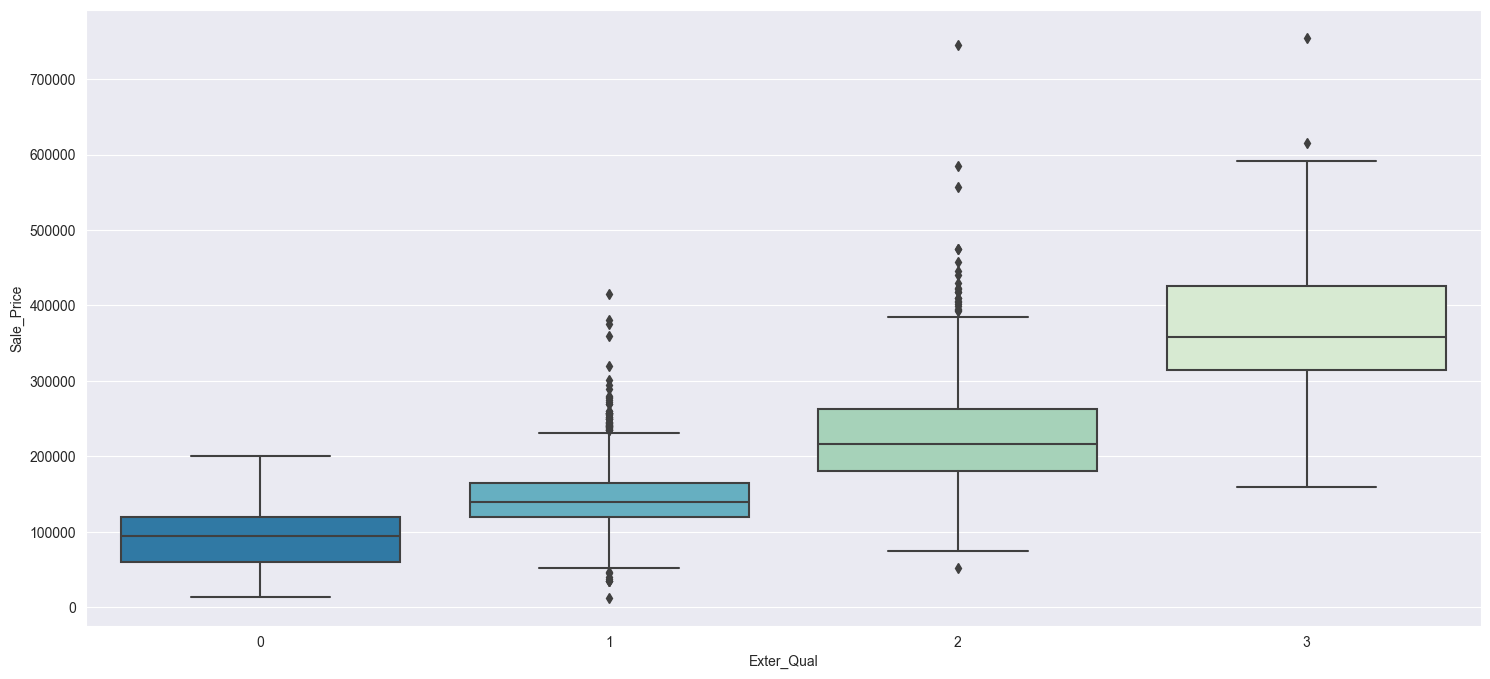

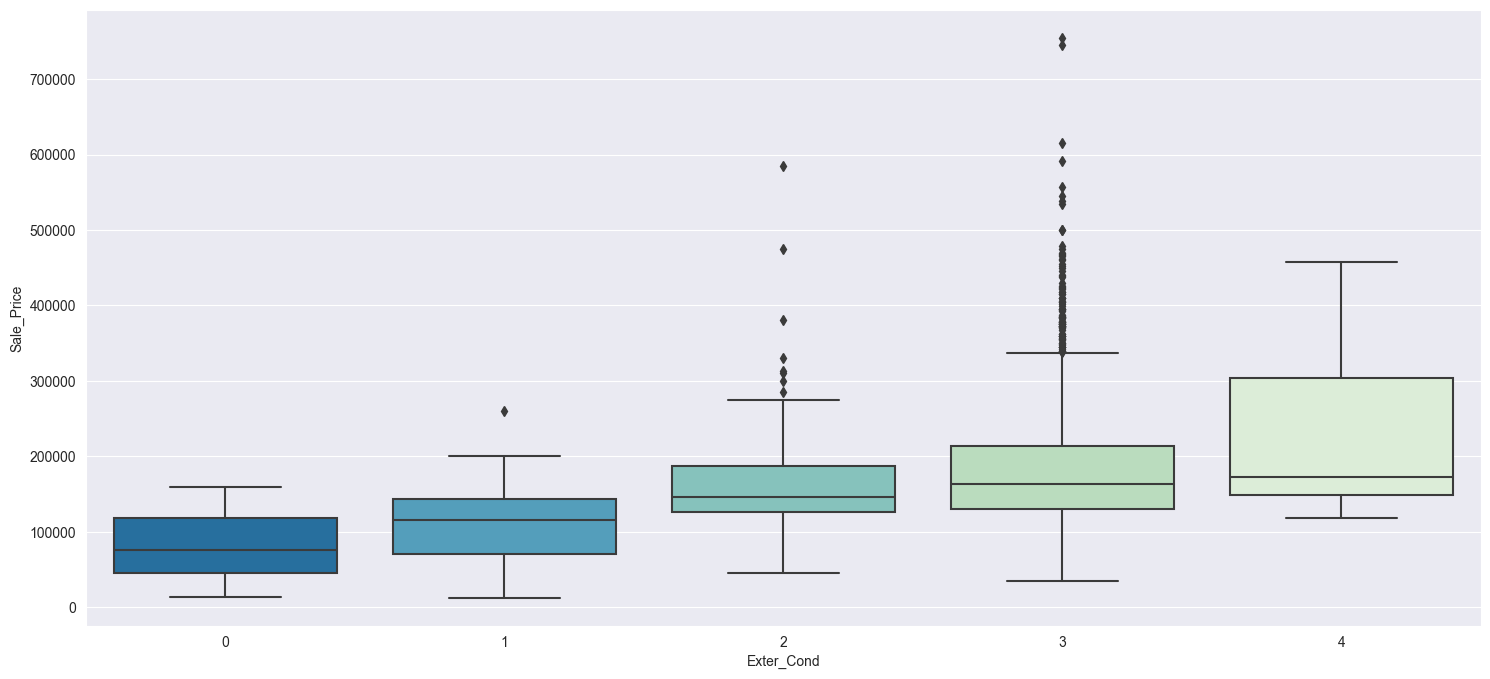

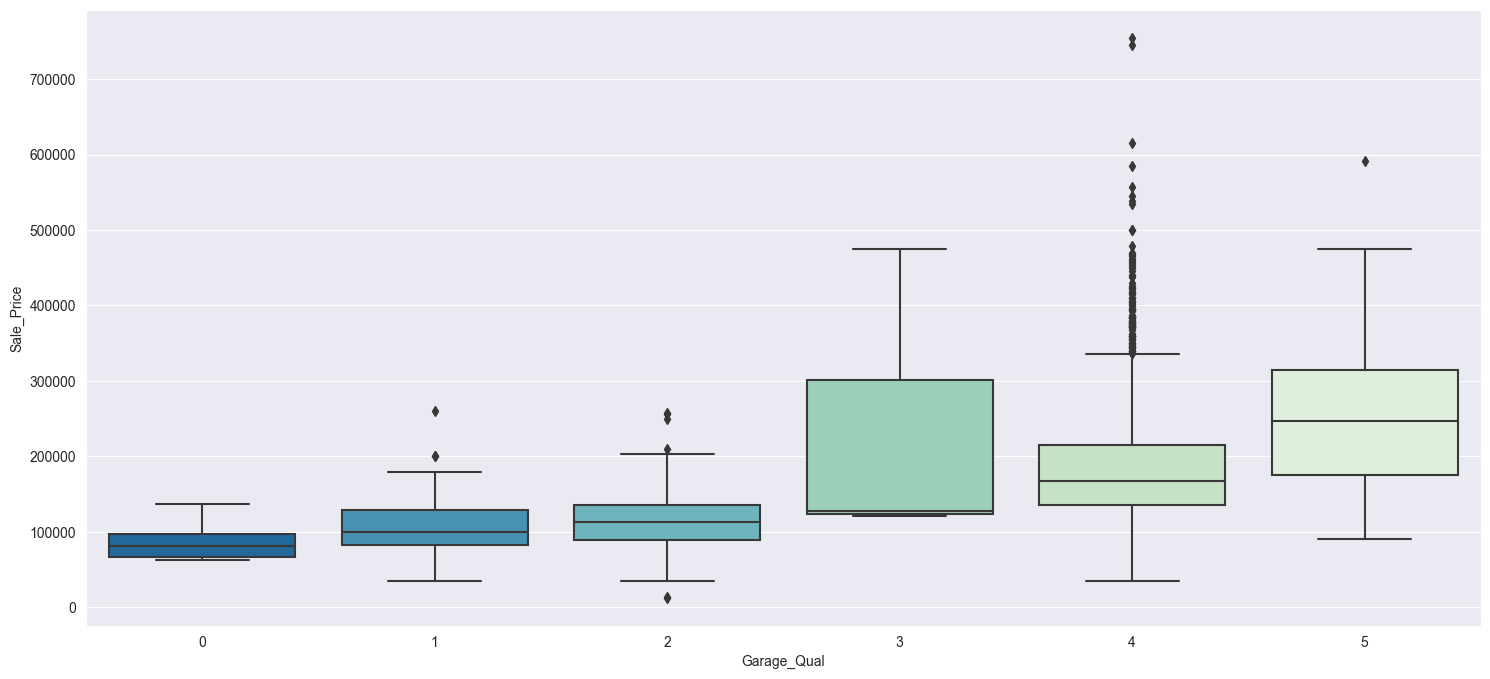

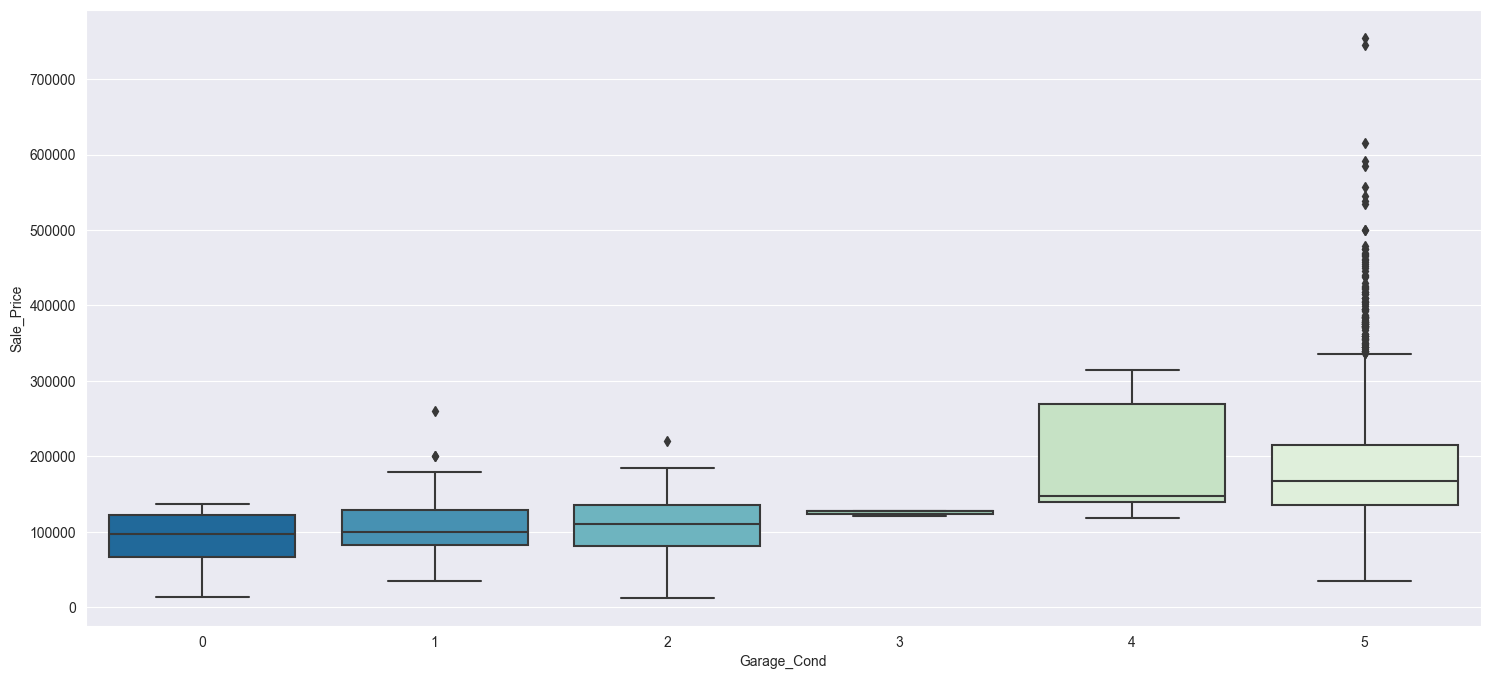

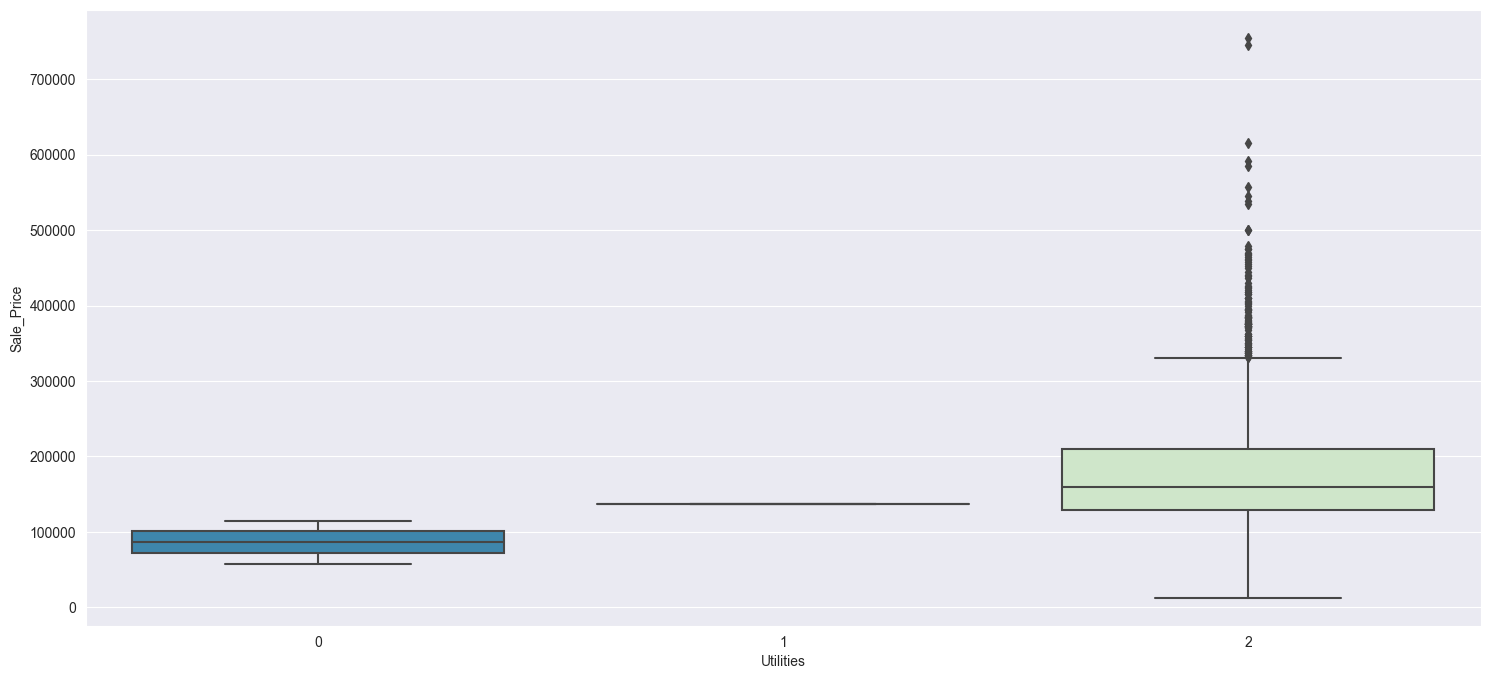

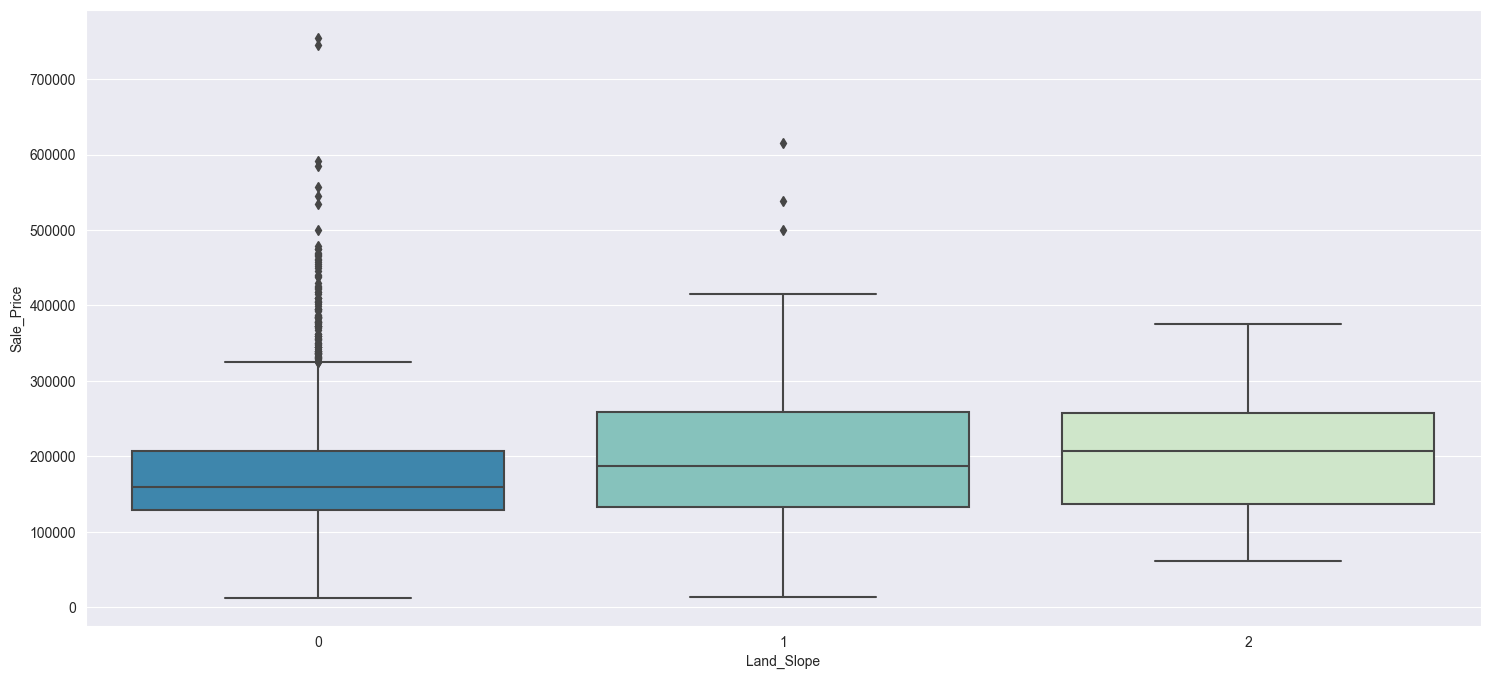

In [98]:
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Kitchen_Qual')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Exter_Qual')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Exter_Cond')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Garage_Qual')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Garage_Cond')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Utilities')
X_train, X_test = refine_data(X_train, Y_train, X_test, 'Land_Slope')

# Outliers
Analizziamo ora il dataset per vedere se vi sono outliers da rimuovere

<AxesSubplot: xlabel='Overall_Qual', ylabel='Sale_Price'>

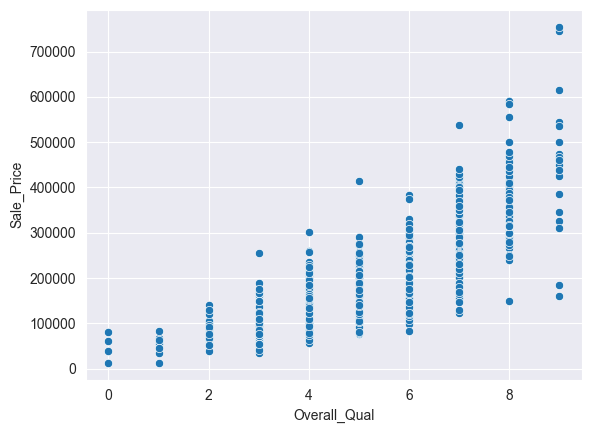

In [99]:
XY_train = pd.concat([X_train, Y_train], axis=1)
sns.scatterplot(x='Overall_Qual', y='Sale_Price', data=XY_train)

In [100]:
XY_train[(XY_train["Sale_Price"] < 200000) & (XY_train["Overall_Qual"] > 8) & (XY_train["Gr_Liv_Area"] > 4000)]

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price
1498,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',313.0,63887.0,b'Pave',b'No_Alley_Access',b'Irregular',b'Bnk',2,b'Corner',...,b'No_Fence',b'None',0.0,1.0,2008.0,b'New',b'Partial',-93.674898,42.016804,160000.0
2180,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',128.0,39290.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Bnk',2,b'Inside',...,b'No_Fence',b'Elev',17000.0,10.0,2007.0,b'New',b'Partial',-93.676220,42.016453,183850.0


Rimuoviamo le seguenti istanze

In [101]:
drop_index = XY_train[
    (XY_train["Sale_Price"] < 200000) & (XY_train["Overall_Qual"] > 8) & (XY_train["Gr_Liv_Area"] > 4000)].index
X_train = X_train.drop(drop_index, axis=0)
Y_train = Y_train.drop(drop_index, axis=0)

# Normalizzazione di Sale_Price

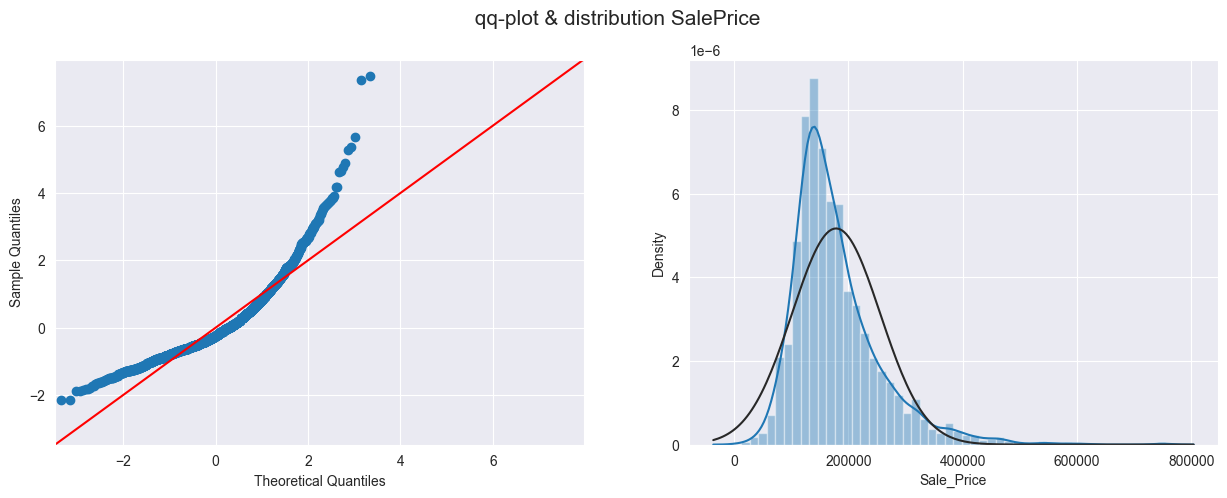

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(Y_train, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])

sns.distplot(Y_train, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

Proviamo a normalizzarla con la log-trasformazione

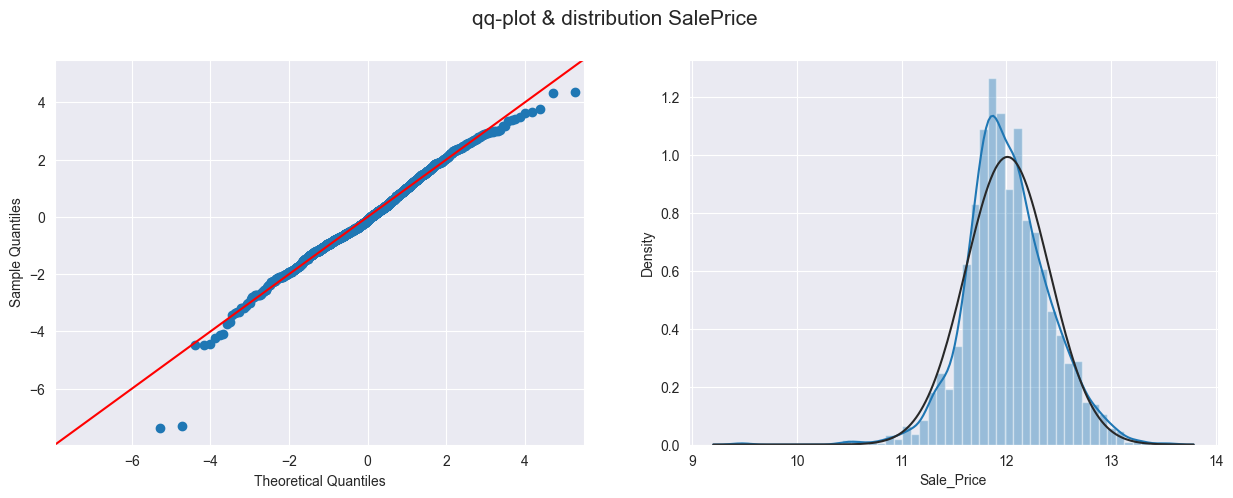

In [103]:
target_log = np.log(Y_train)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(target_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

Y_train = target_log
Y_test = np.log(Y_test)

# Definizione di nuove features
Creiamo le seguenti features:
1. età della casa quando è stata venduta

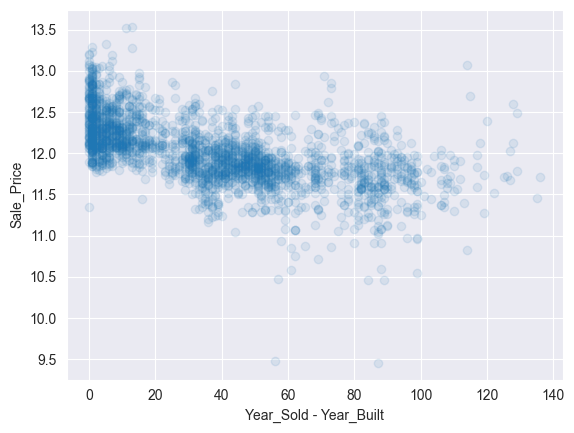

In [104]:
fig, axs = plt.subplots()

axs.plot((X_train.Year_Sold - X_train.Year_Built), Y_train, 'o', alpha=0.1)
axs.set_xlabel('Year_Sold - Year_Built')
axs.set_ylabel('Sale_Price')

X_train['House_Age'] = (X_train.Year_Sold - X_train.Year_Built)
X_test['House_Age'] = (X_test.Year_Sold - X_test.Year_Built)

2. qualità totale della casa

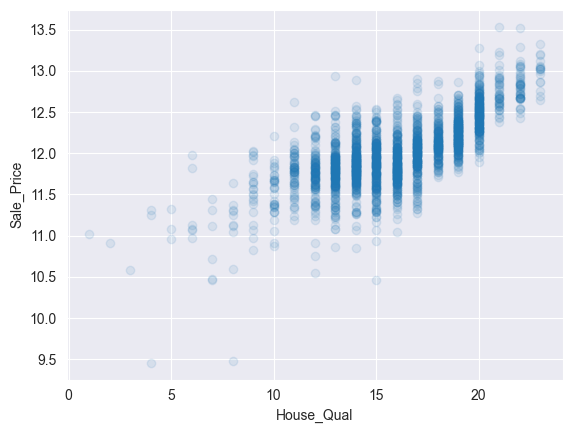

In [105]:
fig, axs = plt.subplots()

axs.plot(X_train.Overall_Qual + X_train.Overall_Cond + X_train.Exter_Qual + X_train.Exter_Cond, Y_train, 'o', alpha=0.1)
axs.set_xlabel('House_Qual')
axs.set_ylabel('Sale_Price')

X_train[
    'House_Qual'] = X_train.Overall_Qual + X_train.Overall_Cond + X_train.Exter_Qual + X_train.Exter_Cond + X_train.Kitchen_Qual
X_test[
    'House_Qual'] = X_test.Overall_Qual + X_test.Overall_Cond + X_test.Exter_Qual + X_test.Exter_Cond + X_test.Kitchen_Qual

3. metri quadrati totali

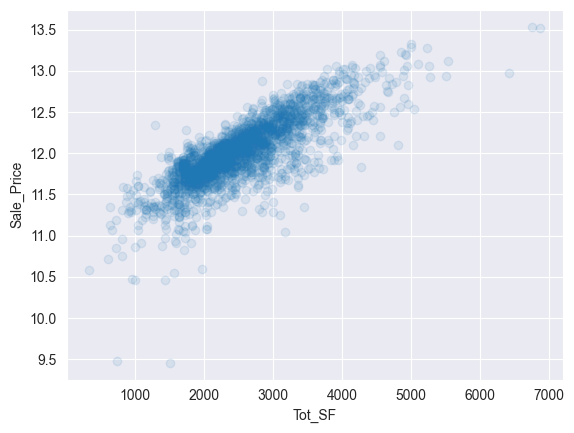

In [106]:
fig, axs = plt.subplots()

axs.plot(X_train.First_Flr_SF + X_train.Second_Flr_SF + X_train.Total_Bsmt_SF, Y_train, 'o', alpha=0.1)
axs.set_xlabel('Tot_SF')
axs.set_ylabel('Sale_Price')

X_train['Tot_SF'] = X_train.First_Flr_SF + X_train.Second_Flr_SF + X_train.Total_Bsmt_SF
X_test['Tot_SF'] = X_test.First_Flr_SF + X_test.Second_Flr_SF + X_test.Total_Bsmt_SF

4. bagni totali

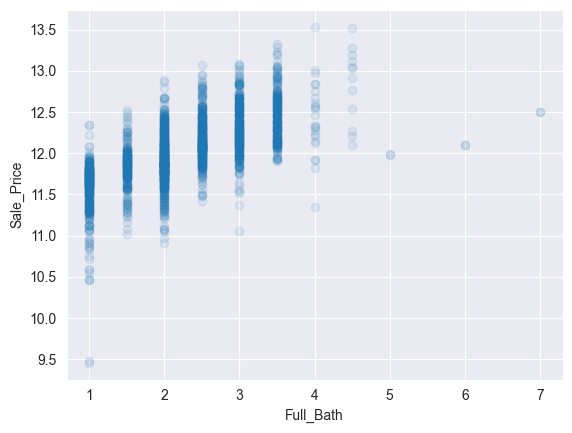

In [107]:
fig, axs = plt.subplots()

axs.plot((X_train.Full_Bath + (0.5 * X_train.Half_Bath) +
          X_train.Bsmt_Full_Bath + (0.5 * X_train.Bsmt_Half_Bath)), Y_train, 'o', alpha=0.1)
axs.set_xlabel('Full_Bath')
axs.set_ylabel('Sale_Price')

X_train["Full_Bath"] = (
            X_train.Full_Bath + (0.5 * X_train.Half_Bath) + X_train.Bsmt_Full_Bath + (0.5 * X_train.Bsmt_Half_Bath))
X_test["Full_Bath"] = (
            X_test.Full_Bath + (0.5 * X_test.Half_Bath) + X_test.Bsmt_Full_Bath + (0.5 * X_test.Bsmt_Half_Bath))

5. metri quadrati per stanza

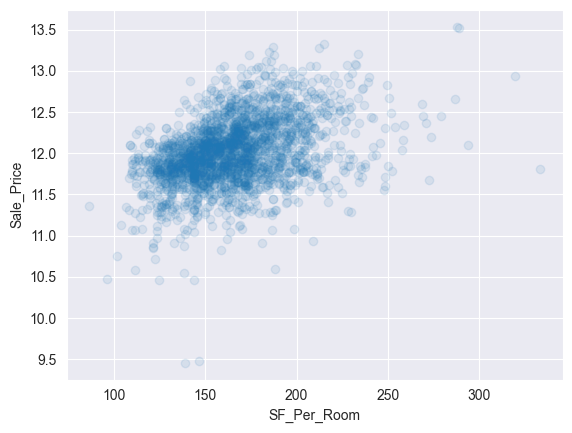

In [108]:
fig, axs = plt.subplots()

axs.plot(X_train.Gr_Liv_Area / (X_train.TotRms_AbvGrd +
                                X_train.Full_Bath +
                                X_train.Half_Bath), Y_train, 'o', alpha=0.1)
axs.set_xlabel('SF_Per_Room')
axs.set_ylabel('Sale_Price')

X_train['SF_Per_Room'] = X_train.Gr_Liv_Area / (
            X_train.TotRms_AbvGrd + X_train.Full_Bath + X_train.Half_Bath + X_train.Kitchen_AbvGr)
X_test['SF_Per_Room'] = X_test.Gr_Liv_Area / (
            X_test.TotRms_AbvGrd + X_test.Full_Bath + X_test.Half_Bath + X_test.Kitchen_AbvGr)

6. numero stanze totali

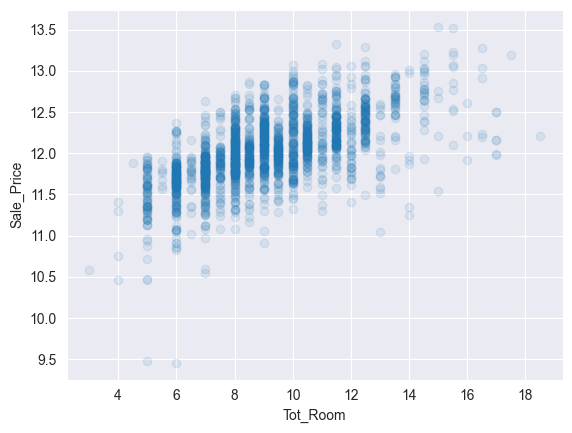

In [109]:
fig, axs = plt.subplots()

axs.plot(X_train.TotRms_AbvGrd +
         X_train.Full_Bath +
         X_train.Half_Bath, Y_train, 'o', alpha=0.1)
axs.set_xlabel('Tot_Room')
axs.set_ylabel('Sale_Price')

X_train['Tot_Room'] = X_train.Gr_Liv_Area / (
            X_train.TotRms_AbvGrd + X_train.Full_Bath + X_train.Half_Bath + X_train.Kitchen_AbvGr)
X_test['Tot_Room'] = X_test.Gr_Liv_Area / (
            X_test.TotRms_AbvGrd + X_test.Full_Bath + X_test.Half_Bath + X_test.Kitchen_AbvGr)

## One hot encoding
Trasformiamo le features discrete

In [110]:
from sklearn.preprocessing import OneHotEncoder

X_train_numerical = X_train.select_dtypes(include=np.number)
X_test_numerical = X_test.select_dtypes(include=np.number)

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse=False, handle_unknown='ignore', min_frequency=0.15, max_categories=5)
oh.fit(X_train[categorical_columns])

X_train_e = oh.transform(X_train[categorical_columns])
X_test_e = oh.transform(X_test[categorical_columns])

for i, col in enumerate(oh.get_feature_names_out()):
    X_train_numerical[col] = X_train_e[:, i]

for i, col in enumerate(oh.get_feature_names_out()):
    X_test_numerical[col] = X_test_e[:, i]

X_train = X_train_numerical
X_test = X_test_numerical

X_train.shape, X_test.shape

((2342, 139), (586, 139))

# Studio della correlazione
plottiamo la matrice di correlazione per le features aventi correlazione maggiore o uguale al 50% con Sale_Price

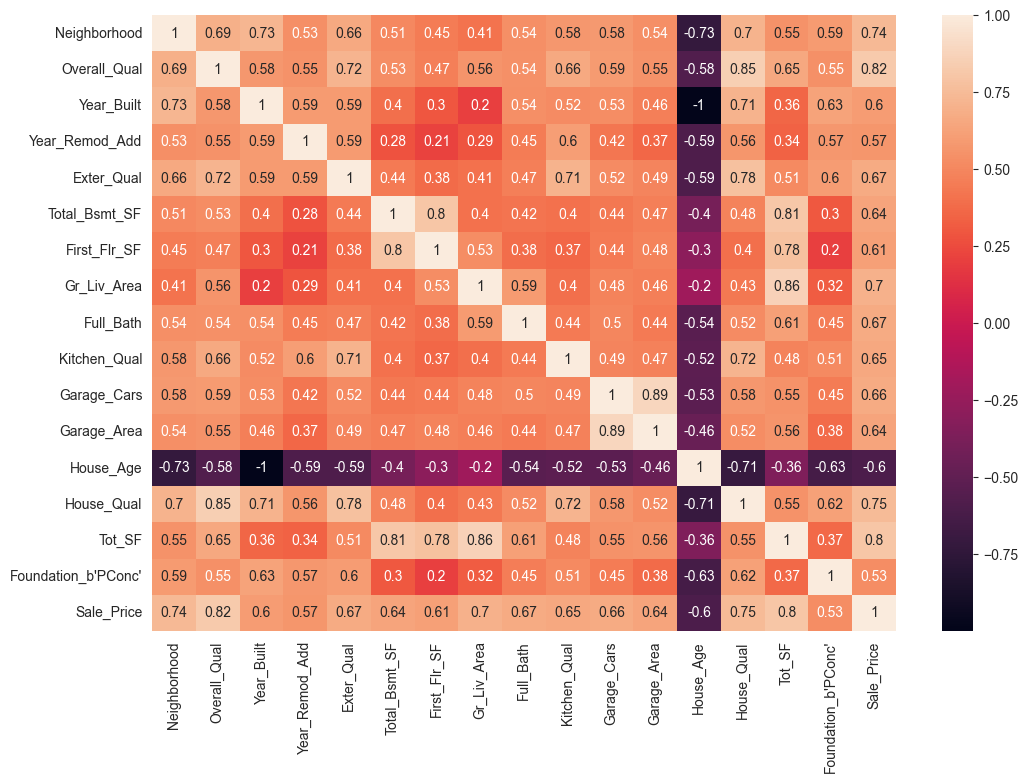

In [111]:
XY_train = pd.concat([X_train, Y_train], axis=1)
corr = XY_train.corr()

top_feature = corr.index[abs(corr['Sale_Price']) > 0.5]
plt.subplots(figsize=(12, 8))
top_corr = XY_train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

# Importanza delle features
Andiamo a studiare l'importanza di ciascuna feature tramite la random forest

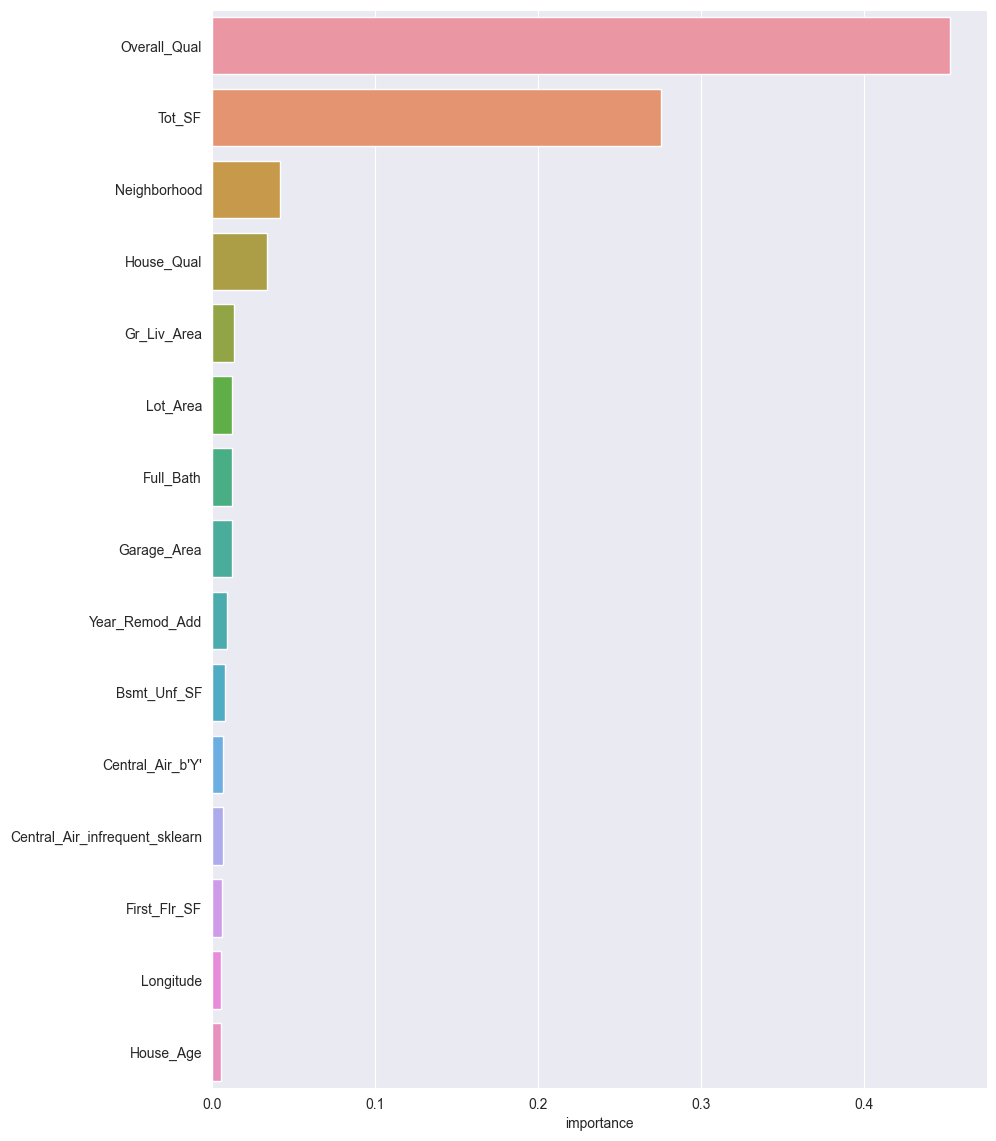

In [112]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=500)
rnd_reg.fit(X_train, Y_train)

feature_importances = pd.DataFrame(rnd_reg.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 14))
sns.barplot(x="importance", y=feature_importances.index[:15], data=feature_importances[:15])
plt.show()

Griglia di plot che ci aiuta a vedere se vi è multicolinearità tra alcune feature

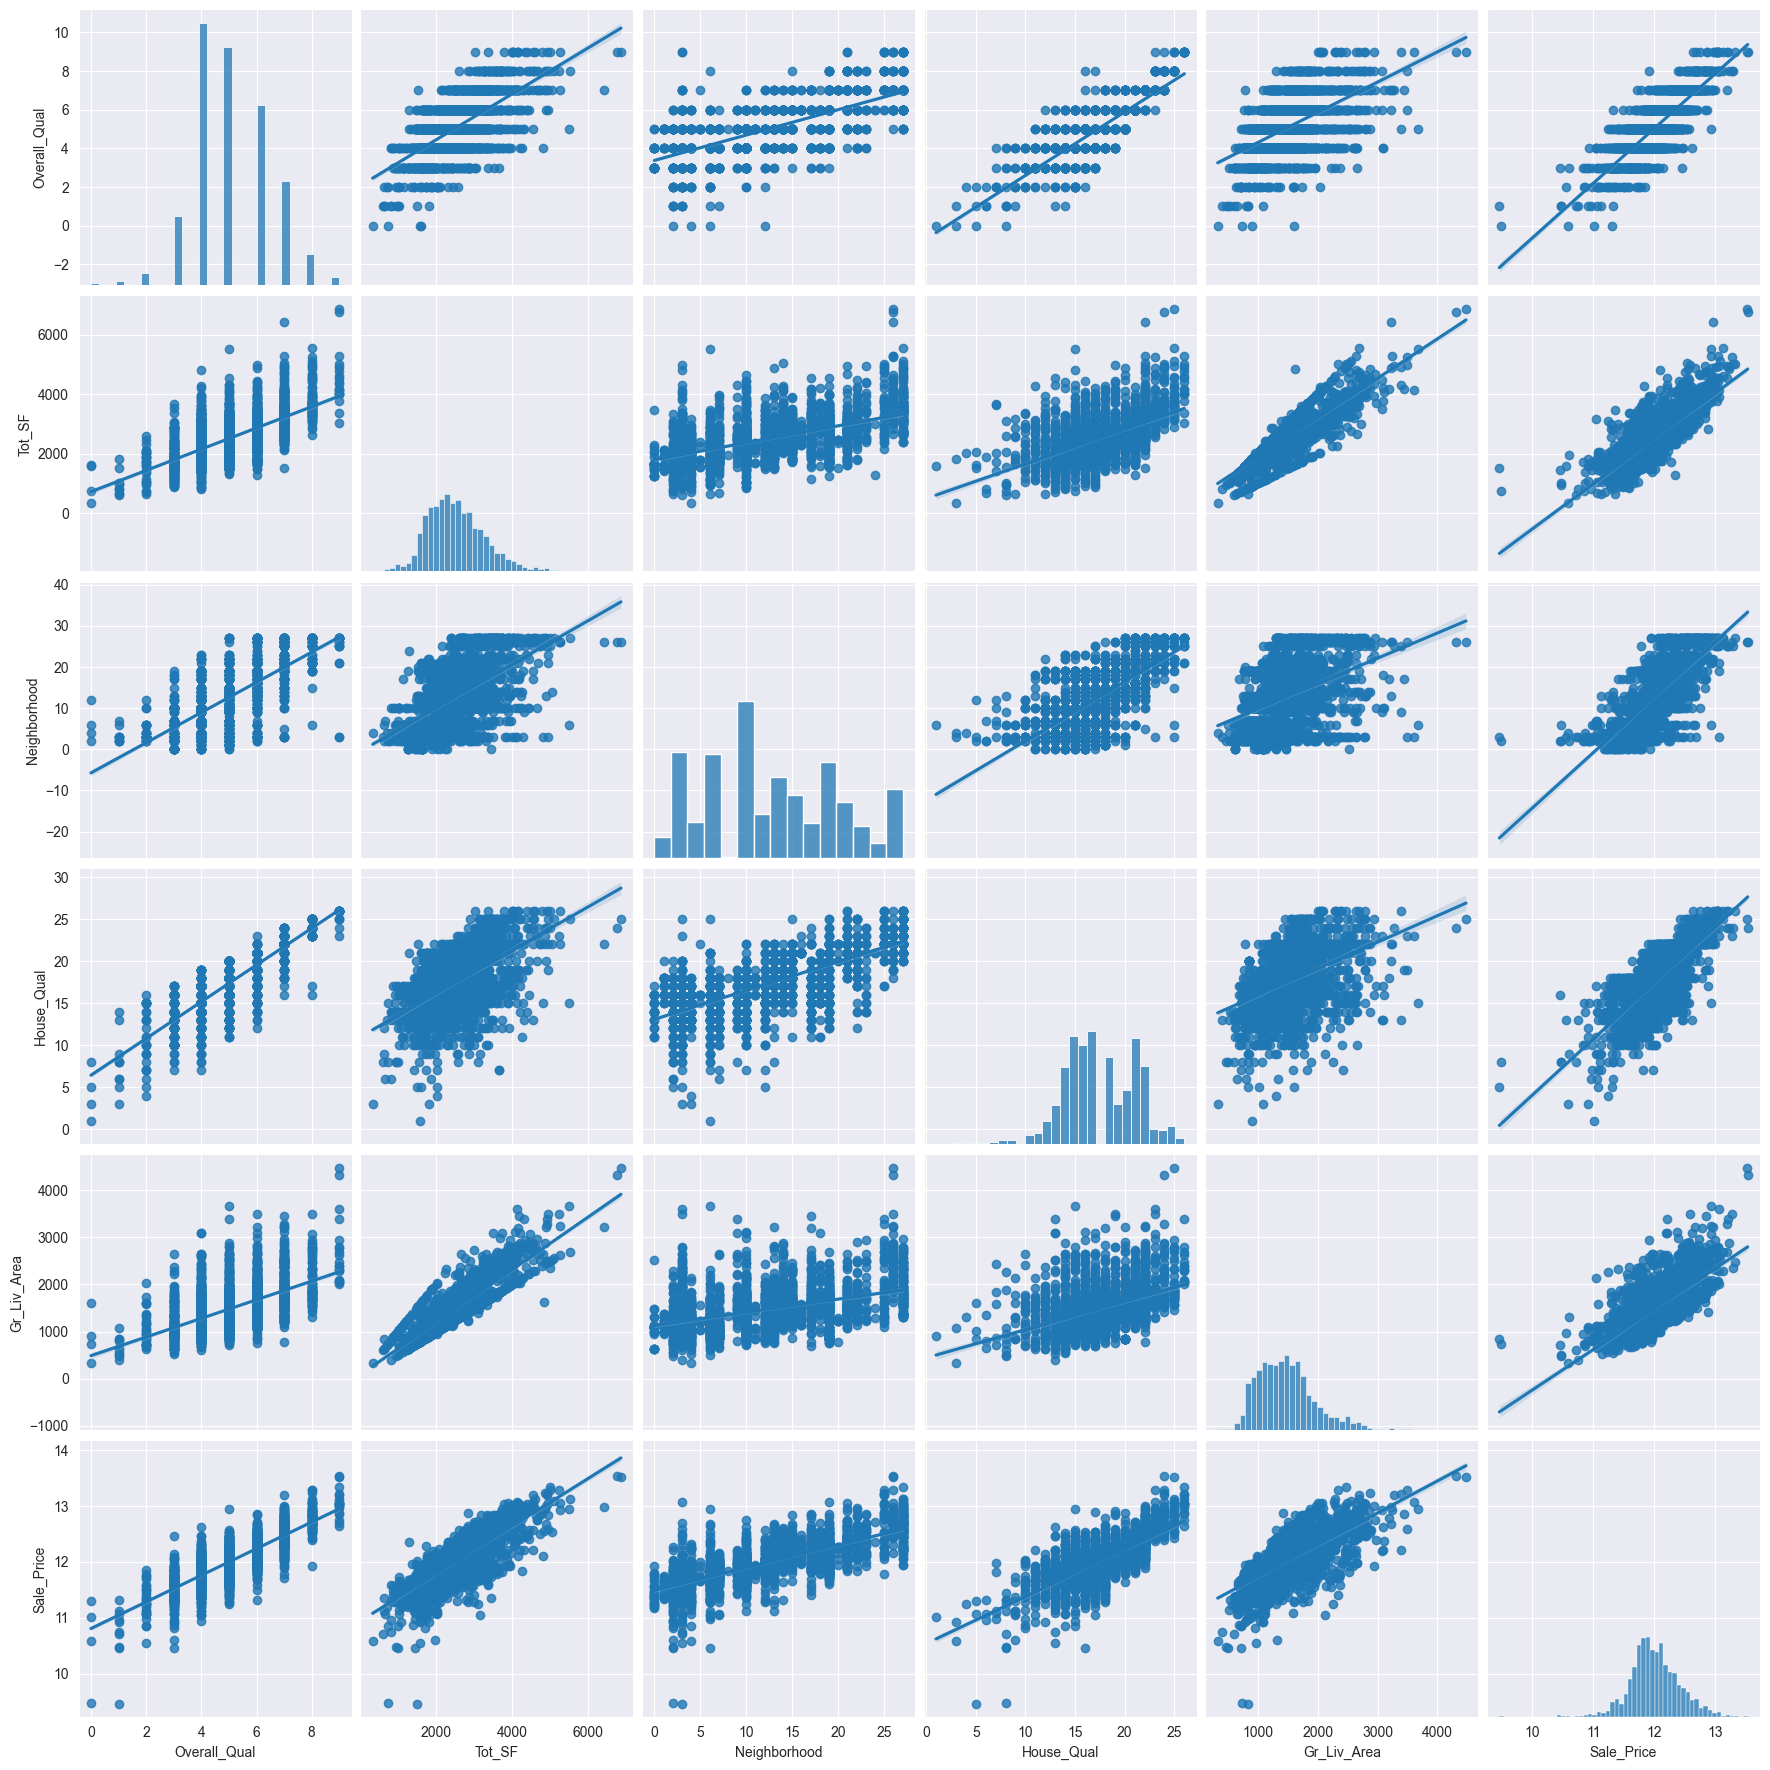

In [113]:
col = feature_importances[:5].index
col = col.to_list() + ['Sale_Price']
sns.pairplot(XY_train[col], height=3, kind='reg')

# Selezione delle feature
Andiamo a ricavare due subset di features tramite la funzione *RFECV* di sklearn, prima usando un DecisionTree e poi una RandomForest

In [114]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Let's apply RFECV algorithm using a DecisionTree
clf = DecisionTreeRegressor()

DT_rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error'
)
DT_rfecv.fit(X_train, Y_train)

print(f"DT Optimal number of features: {DT_rfecv.n_features_}")
print(f'DT Features: {DT_rfecv.get_feature_names_out()}')

#Let's apply RFECV algorithm using a RandomForest which should give the best performance
model = RandomForestRegressor()

RF_rfe = RFECV(
    estimator=model,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
RF_rfe.fit(X_train, Y_train)

print(f"RF Optimal number of features: {RF_rfe.n_features_}")
print(f'RF Features: {RF_rfe.get_feature_names_out()}')

DT Optimal number of features: 64
DT Features: ['Lot_Frontage' 'Lot_Area' 'Land_Slope' 'Neighborhood' 'Overall_Qual'
 'Overall_Cond' 'Year_Built' 'Year_Remod_Add' 'Mas_Vnr_Area' 'Exter_Qual'
 'BsmtFin_SF_1' 'BsmtFin_SF_2' 'Bsmt_Unf_SF' 'Total_Bsmt_SF'
 'First_Flr_SF' 'Second_Flr_SF' 'Gr_Liv_Area' 'Bsmt_Full_Bath' 'Full_Bath'
 'Bedroom_AbvGr' 'Kitchen_AbvGr' 'Kitchen_Qual' 'TotRms_AbvGrd'
 'Fireplaces' 'Garage_Cars' 'Garage_Area' 'Garage_Qual' 'Garage_Cond'
 'Wood_Deck_SF' 'Open_Porch_SF' 'Enclosed_Porch' 'Mo_Sold' 'Year_Sold'
 'Longitude' 'Latitude' 'House_Age' 'House_Qual' 'Tot_SF' 'SF_Per_Room'
 'Tot_Room' "MS_SubClass_b'One_Story_1946_and_Newer_All_Styles'"
 "MS_Zoning_b'Residential_Low_Density'" "Lot_Shape_b'Regular'"
 "Roof_Style_b'Gable'" 'Exterior_1st_infrequent_sklearn'
 "Foundation_b'PConc'" "Bsmt_Qual_b'Typical'"
 'Bsmt_Cond_infrequent_sklearn' 'Bsmt_Exposure_infrequent_sklearn'
 "BsmtFin_Type_1_b'GLQ'" 'BsmtFin_Type_1_infrequent_sklearn'
 "Heating_QC_b'Good'" "Heating_QC_b'T

# Salviamo i dati elaborati in dei file CSV per poterli usare negli altri notebook

In [115]:
X_train.to_csv('./data/X_train.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)
Y_train.to_csv('./data/Y_train.csv', index=False)
Y_test.to_csv('./data/Y_test.csv', index=False)

pd.DataFrame(DT_rfecv.get_feature_names_out()).to_csv('./data/FS_decision_tree.csv', index=False)
pd.DataFrame(RF_rfe.get_feature_names_out()).to_csv('./data/FS_random_forest.csv', index=False)